This notebook displays the results of the quantitative evaluation of SNMF (Section 4.2 of the paper). It relies on the file `results/results_lanl.json.gz`, which is provided as part of the repository and can also be recreated by fully reproducing our experiments.

In [1]:
import gzip
import json

from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as met

from matplotlib.cm import get_cmap

In [2]:
MARKERS = ['o', '^', 's', 'd', '*']
cmap = get_cmap('viridis')
COLORS = [cmap(i / 3) for i in range(4)]

We start by loading the results:

In [3]:
with gzip.open('../results/results_lanl.json.gz', 'rt') as f:
    r = json.loads(f.read())
res = {}
for k, v in r.items():
    if k == 'xs':
        pass
    else:
        d, n = int(k.split('_')[0]), int(k.split('_')[1])
        res[(d, n)] = deepcopy(v)
        xs = np.array(r['xs'])

A few helper functions:

In [4]:
def plot_sensitivity_analysis(res, xs, **kwargs):
    '''
    Plot the ROC AUC as a function of the number of activity
    sources and the total embedding dimension, for each task
    (anomaly detection and link prediction with different
    types of negative edges).
    '''
    fig, axes = plt.subplots(1, 4)
    axes = axes.flatten()
    fig.set_size_inches(10, 2.8)
    n_est_values = (2, 3, 4, 5)
    task_names = {
        'malicious': 'Anomaly detection',
        'easy': 'Link pred. (random)',
        'historical': 'Link pred. (historical)',
        'inductive': 'Link pred. (inductive)'
    }
    for n, n_est in enumerate(n_est_values):
        sub = {
            k[0]: v
            for k, v in res.items()
            if k[1] == n_est
        }
        dims = sorted(list(sub.keys()))
        for i, task in enumerate(
                ('malicious', 'easy', 'historical', 'inductive')
            ):
            aucs = [
                np.array([
                    met.auc(xs, ys)
                    for ys in sub[k]['roc'][task]
                    if ys is not None
                ])
                for k in dims
            ]
            axes[i].errorbar(
                [d + (n - len(n_est_values) / 2) / 3  for d in dims],
                [arr.mean() for arr in aucs],
                yerr=[arr.std() for arr in aucs],
                color=COLORS[n],
                marker=MARKERS[n],
                label=f'{n_est} sources',
                **kwargs
            )
            if n_est == 2:
                axes[i].set_title(task_names[task])
    for i, ax in enumerate(axes):
        ax.set_xlabel('Total dimension')
        ax.set_xticks([10, 20, 30, 40, 50])
        if i == 0:
            axes[i].set_ylabel('AUC')
        ax.grid(axis='y')
    axes[1].legend(
        loc='upper center',
        bbox_to_anchor=(1.18, 1.36),
        ncol=len(n_est_values)
    )
    plt.subplots_adjust(wspace=.36)

In [5]:
def get_best_est_results(res):
    '''
    Select the number of sources and embedding dimension with
    the highest validation score (mean link prediction AUC
    on the validation set).
    '''
    roc = {
        task: []
        for task in ('malicious', 'easy', 'historical', 'inductive')
    }
    ndcg = []
    for s in range(10):
        sub = [
            (
                {k: dat['roc'][k][s] for k in dat['roc']},
                dat['ndcg'][s],
                sum(dat['val_score'][s])
            )
            for dat in res.values()
        ]
        idx = np.argmax([
            val_score for _, _, val_score in sub
        ])
        _roc, _ndcg, _ = sub[idx]
        for task in roc:
            roc[task].append(_roc[task])
        ndcg.append(_ndcg)
    return roc, ndcg

In [6]:
def plot_detection_results(res, xs):
    '''
    Plot the ROC curve for the model with the best validation
    score on each task (anomaly detection and link prediction
    with different types of negative edges).
    '''
    roc, ndcg = get_best_est_results(res)
    
    fig = plt.figure()
    fig.set_size_inches(6, 6)
    
    for k in roc.keys():
        ys = np.stack(roc[k], axis=0)
        auc = np.array([met.auc(xs, y) for y in ys])
        plt.plot(
            xs,
            ys.mean(0),
            label=f'{k} (AUC=${auc.mean():.3f}\\pm{auc.std():.3f}$)'
        )
        plt.fill_between(
            xs,
            ys.mean(0) - ys.std(0),
            ys.mean(0) + ys.std(0),
            alpha=.3
        )
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()
    plt.title('ROC curves')
    
    ndcg = np.array(ndcg)
    plt.suptitle(f'NDCG@1%: ${ndcg.mean():.3f}\\pm{ndcg.std():.3f}$')

First of all, we select the model that performs best on the validation set and analyze its performance on the test set. To that end, we plot the ROC curve for each task and report the AUC as well as the NDCG@1% for the anomaly detection task:

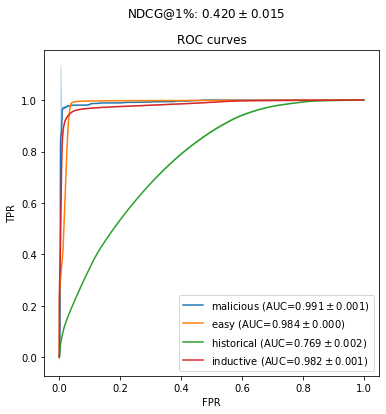

In [7]:
plot_detection_results(res, xs)

Next, we compare the performance obtained for different values of the number of activity sources $L$ and the total embedding dimension $L\cdot{K}$:

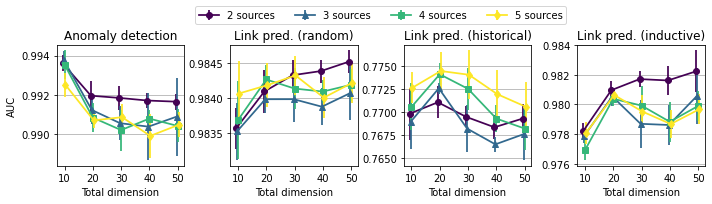

In [8]:
plot_sensitivity_analysis(res, xs, linewidth=1.75)
plt.subplots_adjust(bottom=.2, top=.8, right=.98, left=.08)

Please refer to the paper for a detailed analysis of these results as well as a comparison with several baselines.